###### The University of Melbourne, School of Computing and Information Systems

# COMP30027 Machine Learning, 2024 Semester 1

## Assignment 1: Wine quality classification with K-NN


**Student ID(s):** `1269602`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **


## 1. K-NN classifier


In [32]:
# import numpy as np
# import pandas as pd
# from collections import Counter 
# from scipy.spatial.distance import cosine, mahalanobis
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# class KNNClassifier:
#     def __init__(self, k, distance_metric="euclidean", weighting = None, debug=False):
#         self.k = k
#         self.debug = debug
#         self.distance_metric = distance_metric
#         self.weighting = weighting

#     def distance(self, x1, x2):
#         if self.distance_metric == 'euclidean':
#             return np.sqrt(np.sum((x1 - x2) ** 2))
#         elif self.distance_metric == 'cosine':
#             return cosine(x1, x2)
#         elif self.distance_metric == 'mahalanobis':
#             return mahalanobis(x1, x2, self.inv_covariance_matrix)
        
#     def weight(self, d):
#         if self.weighting == 'inverse':
#             return 1 / (d + 1e-6)  
#         else:
#             return 1 
    
#     def fit(self, X_train, y_train):
#         self.X_train = X_train
#         self.y_train = y_train

#         # Compute the inverse covariance matrix for Mahalanobis distance
#         if self.distance_metric == 'mahalanobis':
#             self.inv_covariance_matrix = np.linalg.inv(np.cov(self.X_train.T))

#     def predict(self, X_test):
#         predictions = []
#         for _, row in X_test.iterrows():
#             # For each instance in test, compute euclidean distance to each instance in training 
#             distances = [self.distance(row.values, x_train) for _, x_train in self.X_train.iterrows()]
#             # Find nearest neighbours and take their labels 
#             nearest_neighbors = np.argsort(distances)[:self.k]
#             nearest_labels = [self.y_train[neighbor] for neighbor in nearest_neighbors]

#             if self.debug:
#                 print("Instance", _)
#                 print("Distance Array", distances)
#                 print(f'Indexes of {self.k} nearest neighbours', nearest_neighbors)
#                 print('With labels:', nearest_labels)

#             if not self.weighting: 
#                 # Majority Vote (when K > 1)
#                 label_counts = Counter(nearest_labels)
#                 most_common = label_counts.most_common()

#                 # Choose winning label
#                 if len(most_common) == 1 or most_common[0][1] > most_common[1][1]:
#                     predictions.append(most_common[0][0])
#                 else:
#                     # Tie-break by taking label of 1-NN 
#                     predictions.append(nearest_labels[0])

#             # use weighted approach to label
#             else:
#                 weights = np.array([self.weight(distances[i]) for i in nearest_neighbors])
#                 weighted_counts = np.bincount(nearest_labels, weights=weights, minlength=2)
#                 predictions.append(np.argmax(weighted_counts))
        
#         return predictions

In [31]:
import numpy as np
import pandas as pd
from collections import Counter 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.spatial.distance import cdist

class KNNClassifier:
    def __init__(self, k, distance_metric="euclidean", weighting=None, debug=False):
        self.k = k
        self.debug = debug
        self.distance_metric = distance_metric
        self.weighting = weighting

    def distance(self, x1, x2):
        if self.distance_metric == 'euclidean':
            return np.linalg.norm(x1 - x2)
        elif self.distance_metric == 'cosine':
            return 1 - np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))
        elif self.distance_metric == 'mahalanobis':
            return np.sqrt(np.dot(np.dot((x1 - x2), self.inv_covariance_matrix), (x1 - x2)))

    def weight(self, d):
        if self.weighting == 'inverse':
            return 1 / (d + 1e-6)
        else:
            return 1

    def fit(self, X_train, y_train):
        self.X_train = X_train.values
        self.y_train = y_train.values

        # Compute the inverse covariance matrix for Mahalanobis distance
        if self.distance_metric == 'mahalanobis':
            self.inv_covariance_matrix = np.linalg.inv(np.cov(self.X_train.T))

    def predict(self, X_test):
        predictions = []
        X_test = X_test.values
        for x_test in X_test:
            # Compute distances to all training samples
            distances = cdist([x_test], self.X_train, metric=self.distance_metric).ravel()

            # Sort distances and indices to get nearest neighbors
            nearest_indices = np.argsort(distances)[:self.k]
            nearest_labels = self.y_train[nearest_indices]

            if not self.weighting:
                # Majority voting
                prediction = Counter(nearest_labels).most_common(1)[0][0]
            else:
                # Compute weights for nearest neighbors
                weights = np.array([self.weight(distances[i]) for i in nearest_indices])
                weighted_counts = np.bincount(nearest_labels, weights=weights, minlength=2)
                # Predict the label with the highest weighted count
                prediction = np.argmax(weighted_counts)

            predictions.append(prediction)

        return predictions


In [33]:
# Read training and testing dataset into dataframes
train_df = pd.read_csv("winequality-train.csv")
test_df = pd.read_csv("winequality-test.csv")

print(train_df.head())

   fixedAcidity  volatileAcidity  citricAcid  residualSugar  chlorides  \
0           7.9             0.18        0.37           1.20      0.040   
1           8.3             0.42        0.62          19.25      0.040   
2           6.6             0.17        0.38           1.50      0.032   
3           6.2             0.66        0.48           1.20      0.029   
4           6.5             0.31        0.14           7.50      0.044   

   freeSulfurDioxide  totalSulfurDioxide  density    pH  sulphates  alcohol  \
0               16.0                75.0   0.9920  3.18       0.63     10.8   
1               41.0               172.0   1.0002  2.98       0.67      9.7   
2               28.0               112.0   0.9914  3.25       0.55     11.4   
3               29.0                75.0   0.9892  3.33       0.39     12.8   
4               34.0               133.0   0.9955  3.22       0.50      9.5   

   quality  
0        0  
1        0  
2        1  
3        1  
4        0  


In [34]:
# Calculate the distribution of labels 
def calc_prior(data):
    prior_prob = {}

    labels = data['quality']
    unique_labels, counts = np.unique(labels, return_counts=True)
    n = counts.sum()

    for i in range(len(unique_labels)):
        prior_prob[unique_labels[i]] = (counts[i] / n).round(2)

    return prior_prob

In [35]:
# Separate features and class for training df
X_train = train_df.drop(columns=['quality'])
y_train = train_df['quality']

# Separate features and class for testing df
X_test = test_df.drop(columns=['quality'])
y_test = test_df['quality']

print(X_train.head())
print(y_train.head())
print(X_test.head())
print(y_test.head())

   fixedAcidity  volatileAcidity  citricAcid  residualSugar  chlorides  \
0           7.9             0.18        0.37           1.20      0.040   
1           8.3             0.42        0.62          19.25      0.040   
2           6.6             0.17        0.38           1.50      0.032   
3           6.2             0.66        0.48           1.20      0.029   
4           6.5             0.31        0.14           7.50      0.044   

   freeSulfurDioxide  totalSulfurDioxide  density    pH  sulphates  alcohol  
0               16.0                75.0   0.9920  3.18       0.63     10.8  
1               41.0               172.0   1.0002  2.98       0.67      9.7  
2               28.0               112.0   0.9914  3.25       0.55     11.4  
3               29.0                75.0   0.9892  3.33       0.39     12.8  
4               34.0               133.0   0.9955  3.22       0.50      9.5  
0    0
1    0
2    1
3    1
4    0
Name: quality, dtype: int64
   fixedAcidity  volatil

Results:
      Predicted  True Label
0             0           0
1             0           0
2             0           1
3             1           1
4             1           1
...         ...         ...
1345          1           1
1346          0           1
1347          1           0
1348          0           0
1349          1           1

[1350 rows x 2 columns]

Overall Accuracy: 74.15%


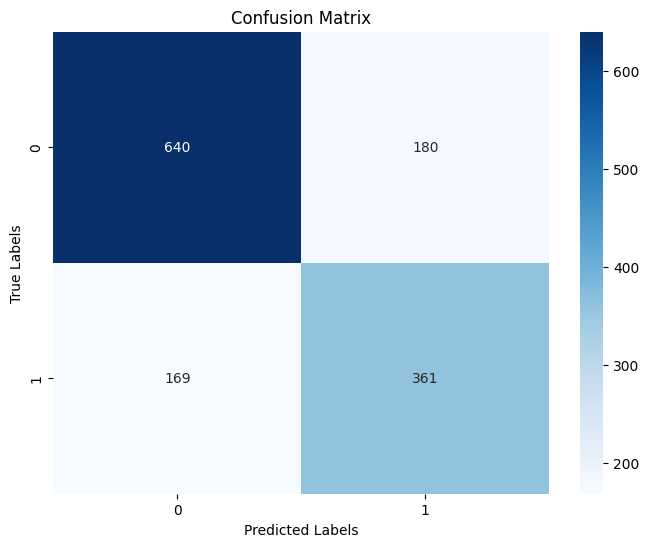

In [61]:
# Initiate the KNN classifier and fit it to the training data 
knn = KNNClassifier(k=5, debug=False)
knn.fit(X_train, y_train)

# Visualise the predictions made by KNN Classifier
# Make predictions on the test data
predictions = knn.predict(X_test)
true_labels = y_test

results_df = pd.DataFrame({'Predicted': predictions, 'True Label': true_labels})

# Calculate accuracy
accuracy = round(np.mean(predictions == true_labels) * 100, 2)

print("Results:")
print(results_df)
print(f"\nOverall Accuracy: {accuracy}%")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 2. 1-NN classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.


In [60]:
# Initiate 1-NN classifier and fit it to the training data 
knn = KNNClassifier(k=1, debug=False)
knn.fit(X_train, y_train)

# Visualise the predictions made by KNN Classifier
# Make predictions on the test data
predictions = knn.predict(X_test)
true_labels = y_test

results_df = pd.DataFrame({'Predicted': predictions, 'True Label': true_labels})

# Calculate accuracy
accuracy = round(np.mean(predictions == true_labels) * 100, 2)

print("Results for the first", num_instances, "instances:")
print(results_df)
print(f"\nOverall Accuracy: {accuracy}%")

Results for the first 1350 instances:
      Predicted  True Label
0             0           0
1             0           0
2             1           1
3             1           1
4             1           1
...         ...         ...
1345          1           1
1346          0           1
1347          1           0
1348          0           0
1349          1           1

[1350 rows x 2 columns]

Overall Accuracy: 76.44%


Is this dataset suitable for 1-NN classification? 

Attributes: fixedAcidity, volatileAcidity, citricAcid, residualSugar, chlorides, freeSulfurDioxide, totalSulfurDioxide, density, pH, sulphates, alcohol, quality

Considerations for 1-NN Classifiers: The bias is low and variance is high. The probability of modelling the noise in the training data is high. 

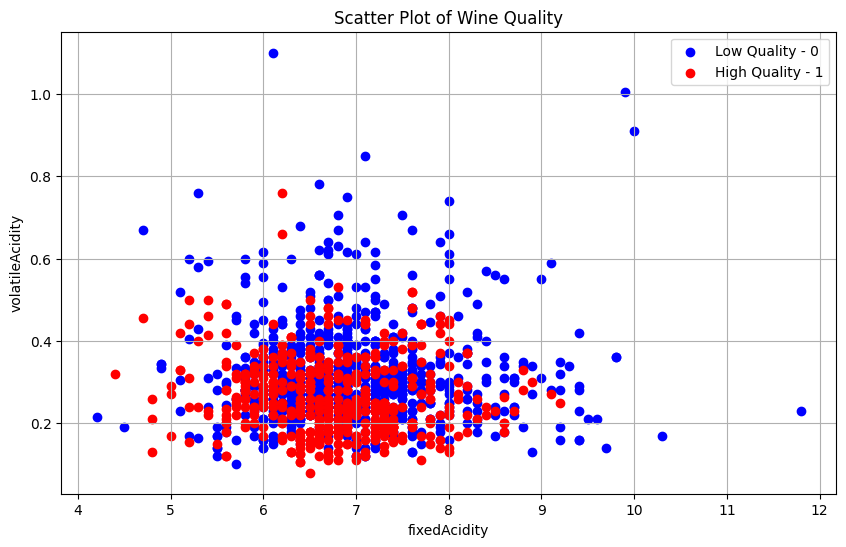

In [38]:
# 2D scatter plot of the 2 attributes above
attribute1 = 'fixedAcidity'
attribute2 = 'volatileAcidity'
attribute3 = 'citricAcid'
attribute4 = 'residualSugar'
attribute5 = 'chlorides'
attribute6 = 'freeSulfurDioxide'
attribute7 = 'totalSulfurDioxide'
attribute8 = 'density'
attribute9 = 'pH'
attribute10 = 'sulphates'
attribute11 = 'alcohol'

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(train_df[train_df['quality'] == 0][attribute1], train_df[train_df['quality'] == 0][attribute2], c='blue', label='Low Quality - 0')
plt.scatter(train_df[train_df['quality'] == 1][attribute1], train_df[train_df['quality'] == 1][attribute2], c='red', label='High Quality - 1')

# Add labels and title
plt.xlabel(attribute1)
plt.ylabel(attribute2)
plt.title('Scatter Plot of Wine Quality')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

## 3. Normalization

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.


1. Min-max scale all attributes to the range 0 − 1: 
    $x′ = \frac{x−min(x)}{max(x)−min(x)}$

In [39]:
def min_max_scaling(train_df, test_df):
    scaled_train_df = train_df.copy()
    scaled_test_df = test_df.copy()

    for col in train_df.columns:
        min_val = train_df[col].min()
        max_val = train_df[col].max()

        scaled_train_df[col] = (train_df[col] - min_val) / (max_val - min_val)
        scaled_test_df[col] = (test_df[col] - min_val) / (max_val - min_val)

    return scaled_train_df, scaled_test_df

scaled_train_df, scaled_test_df = min_max_scaling(train_df, test_df)
scaled_X_train = scaled_train_df.drop(columns=['quality'])
scaled_X_test = scaled_test_df.drop(columns=['quality'])

In [59]:
# Initiate 1-NN classifier and fit it to the scaled training data 
knn = KNNClassifier(k=1, debug=False)
knn.fit(scaled_X_train, y_train)

# Visualise the predictions made by KNN Classifier
# Make predictions on the scaled test data
predictions = knn.predict(scaled_X_test)
true_labels = y_test

results_df = pd.DataFrame({'Predicted': predictions, 'True Label': true_labels})

# Calculate accuracy
accuracy = round(np.mean(predictions == true_labels) * 100, 2)

print("Results for the first", num_instances, "instances:")
print(results_df)
print(f"\nOverall Accuracy: {accuracy}%")

Results for the first 1350 instances:
      Predicted  True Label
0             1           0
1             0           0
2             1           1
3             1           1
4             0           1
...         ...         ...
1345          1           1
1346          1           1
1347          1           0
1348          0           0
1349          1           1

[1350 rows x 2 columns]

Overall Accuracy: 85.04%


2. Standardize all attributes to have mean of 0 and standard deviation of 1
    $x′ = \frac{x−mean(x)}{stdev(x)}$

In [41]:
def standardize(train_df, test_df):
    standardized_train_df = train_df.copy()
    standardized_test_df = test_df.copy()

    mean_vals = train_df.mean()
    std_vals = train_df.std()

    for col in train_df.columns:
        standardized_train_df[col] = (train_df[col] - mean_vals[col]) / std_vals[col]
        standardized_test_df[col] = (test_df[col] - mean_vals[col]) / std_vals[col]

    return standardized_train_df, standardized_test_df

standardized_train_df, standardized_test_df = standardize(train_df, test_df)
standardized_X_train = standardized_train_df.drop(columns=['quality'])
standardized_X_test = standardized_test_df.drop(columns=['quality'])

In [58]:

# Initiate 1-NN classifier and fit it to the standardized training data 
knn = KNNClassifier(k=1, debug=False)
knn.fit(standardized_X_train, y_train)

# Visualise the predictions made by KNN Classifier
# Make predictions on the standardized test data
std_predictions = knn.predict(standardized_X_test)
true_labels = y_test

results_df = pd.DataFrame({'Predicted': std_predictions, 'True Label': true_labels})

# Calculate accuracy
accuracy = round(np.mean(std_predictions == true_labels) * 100, 2)

print("Results for the first", num_instances, "instances:")
print(results_df)
print(f"\nOverall Accuracy: {accuracy}%")

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, std_predictions)

# Display confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Results for the first 1350 instances:
      Predicted  True Label
0             0           0
1             0           0
2             1           1
3             1           1
4             1           1
...         ...         ...
1345          1           1
1346          1           1
1347          1           0
1348          0           0
1349          1           1

[1350 rows x 2 columns]

Overall Accuracy: 86.74%
Confusion Matrix:
[[709 111]
 [ 68 462]]


## 4. Model extensions

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.


### 4.1

Compare the performance of your best 1-NN model from Question 3 to a Gaussian naive Bayes model on this dataset (you may use library functions to implement the Gaussian naive Bayes model). In your write-up, state the accuracy of the naive Bayes model and identify instances where the two models disagree. Why do the two models classify these instances differently?


In [56]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train, y_train)

gnb_y_pred = gnb.predict(X_test)
acc = gnb.score(X_test, y_test)

results_df = pd.DataFrame({'Predicted_GNB': gnb_y_pred, 'Predicted_1NN': std_predictions, 'True Label': y_test})

print(results_df)
print(f"GNB Accuracy: {round(acc*100, 2)}%")

inconsistent_cases = results_df[results_df['Predicted_GNB'] != results_df['Predicted_1NN']]

# Select rows from X_test corresponding to the inconsistent indices
inconsistent_indices = inconsistent_cases.index
inconsistent_X_test = X_test.iloc[inconsistent_indices]

# Print the selected rows
print()
print("Rows of X_test corresponding to inconsistent predictions:")
print(inconsistent_X_test)

      Predicted_GNB  Predicted_1NN  True Label
0                 1              0           0
1                 0              0           0
2                 1              1           1
3                 1              1           1
4                 1              1           1
...             ...            ...         ...
1345              1              1           1
1346              1              1           1
1347              1              1           0
1348              0              0           0
1349              1              1           1

[1350 rows x 3 columns]
GNB Accuracy: 77.78%

Rows of X_test corresponding to inconsistent predictions:
      fixedAcidity  volatileAcidity  citricAcid  residualSugar  chlorides  \
0              8.1            0.270        0.41           1.45      0.033   
9              6.2            0.160        0.33           1.10      0.057   
18             7.4            0.250        0.37          13.50      0.060   
19             7.4     

### 4.2

Implement two additional distance measures for your K-NN model: cosine similarity and Mahalanobis distance (you may use library functions for these distance measures). Do 1-NN classification using each of these new distance measures and the three normalization options from Question 3. Discuss how the new distance metrics compare to Euclidean distance and how each metric is affected by normalization.


In [53]:
distances = {'euclidean': [], 'cosine': [], 'mahalanobis': []}

for dist in distances.keys():
    knn = KNNClassifier(k=1, distance_metric=dist)
    accuracies = []

    # no normalization
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    accuracy = round(np.mean(predictions == y_test) * 100, 2)   
    
    # min-max normalization
    knn.fit(scaled_X_train, y_train)
    predictions_min_max = knn.predict(scaled_X_test)
    accuracy_min_max = round(np.mean(predictions_min_max == y_test) * 100, 2)


    # euclidean - standardized normalization 
    knn.fit(standardized_X_train, y_train)
    predictions_std = knn.predict(standardized_X_test)
    accuracy_std = round(np.mean(predictions_std == y_test) * 100, 2)

    # append accuracies 
    accuracies.append(accuracy)
    accuracies.append(accuracy_min_max)
    accuracies.append(accuracy_std)

    distances[dist] = accuracies


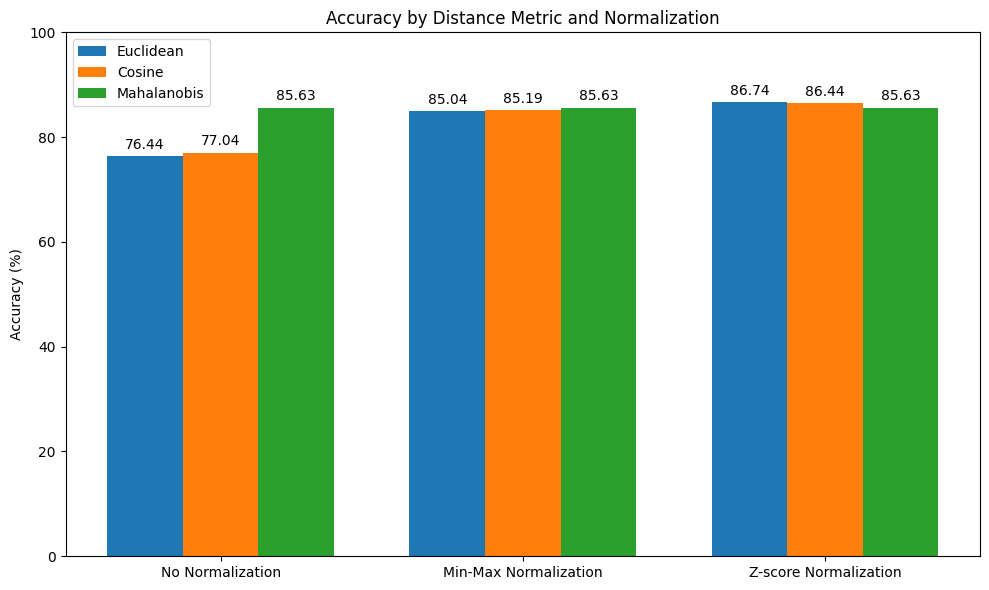

In [54]:
# Visualise this information
# Labels
labels = ['No Normalization', 'Min-Max Normalization', 'Z-score Normalization']

# Plot
x = np.arange(len(labels)) 
width = 0.25 

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, distances['euclidean'], width, label='Euclidean')
rects2 = ax.bar(x, distances['cosine'], width, label='Cosine')
rects3 = ax.bar(x + width, distances['mahalanobis'], width, label='Mahalanobis')

ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy by Distance Metric and Normalization')
ax.set_xticks(x)
ax.set_ylim(0, 100) 
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

ax.legend(loc='upper left', bbox_to_anchor=(0, 1))

fig.tight_layout()

plt.show()

### 4.3

Implement either of the two K-NN weighting strategies discussed in lecture (inverse linear distance or inverse distance). Compare the performance of the weighted and majority vote models for a few different values of K. In your write-up, discuss how weighting strategy and the value of K affect the model's decisions.


In [48]:
# Define values of K to test
k_values = [1, 3, 5, 7, 9]

for k in k_values:
    # Majority vote model
    knn_majority = KNNClassifier(k=k)
    knn_majority.fit(X_train, y_train)
    predictions_majority = knn_majority.predict(X_test)
    accuracy_majority = np.mean(predictions_majority == y_test)

    # Weighted model with inverse distance
    knn_weighted_inverse = KNNClassifier(k=k, weighting='inverse')
    knn_weighted_inverse.fit(X_train, y_train)
    predictions_weighted_inverse = knn_weighted_inverse.predict(X_test)
    accuracy_weighted_inverse = np.mean(predictions_weighted_inverse == y_test)

    print(f'K={k}:')
    print(f' Majority Vote Accuracy: {accuracy_majority:.4f}')
    print(f' Weighted (Inverse Distance) Accuracy: {accuracy_weighted_inverse:.4f}')

K=1:
 Majority Vote Accuracy: 0.7644
 Weighted (Inverse Distance) Accuracy: 0.7644
K=3:
 Majority Vote Accuracy: 0.7548
 Weighted (Inverse Distance) Accuracy: 0.7867
K=5:
 Majority Vote Accuracy: 0.7415
 Weighted (Inverse Distance) Accuracy: 0.7785
K=7:
 Majority Vote Accuracy: 0.7385
 Weighted (Inverse Distance) Accuracy: 0.7904
K=9:
 Majority Vote Accuracy: 0.7333
 Weighted (Inverse Distance) Accuracy: 0.7926


### 4.4

Measure the empirical distribution of class labels in the training dataset (what percentage of the training data comes from each class). Then evaluate the distribution of labels predicted by your K-NN model for the test data, for a range of values for K. Does the class distribution of the predicted labels match the class distribution of the training data? Explain why or why not.


In [ ]:
# Visualise training dataset split 
prior_probs = calc_prior(train_df)

# Convert numerical keys to strings
prior_probs_str = {str(key): value for key, value in prior_probs.items()}

# Plotting
plt.bar(prior_probs_str.keys(), prior_probs_str.values())
plt.xlabel('Wine Quality')
plt.ylabel('Prior Probability')
plt.title('Distribution of Labels in Training Dataset')
plt.show()